# Setup
To setup this whole Jupyter-Notebook, the following code needs to be executed. It imports the general libraries and sets the utils classes.

In [ ]:
import sys
import os
from pydub import AudioSegment # type: ignore
from utils.logger_handler import Logger
from utils.setup_helper import SetupHelper
from pathlib import Path
import subprocess

# Setup Logger
logger = Logger()
original_stdout = sys.stdout  # Save the original stdout
sys.stdout = logger  # Redirect stdout to logger

#Load Config
ae_config = SetupHelper("audio_editing", os.getcwd())
config_data = ae_config.getConfigValues()

# Setup
Make sure to create the folder "audio" and the subfolder "ambient" if it is not already present from the repository. Place your files to make the ambient sound inside of it. Additionally, your files to be merged should be in the subfolder "audio/synthesized_audio". To check this structure is correct, we define the following code.

In [2]:
def getFileStructureInfo (cwd: str):
    """Checking if the file structure has all needed files to start editing audio.

    Args:
        cwd (str): String to the current working directory
    """
    # Check if Output folder exists
    if not Path(config_data['output_dir']).exists():
        print(f"'final_audio' Folder not found. Creating Folder.")
        Path(config_data['output_dir']).mkdir(parents=True, exist_ok=True)
    
    # Check if synthesized audios exist
    if not Path(config_data['source_dir']).exists():
        print(f"'audio/synthesized_audio' does not exist, make sure to create the folder and add your audio files there")
        sys.exit()
    
    # Check if ambient files have been added correctly  
    if not Path(config_data['ambient_dir']).exists():
        print(f"'audio/ambient' does not exist, make sure to create the folder and add your ambient audio files there")
        sys.exit()
        
getFileStructureInfo(os.getcwd())  

# Increasing the volume of the ambient layer
To test the audio files with increasingly louder ambient sounds to see, which impact the software more, we use the following scale:

### Summary of Anchor Points for Testing Ambient Files:
- Silence: -90 dBFS 
- Very Quiet: -60 dBFS, -55 dBFS, -50 dBFS
- Moderate Ambient Noise: -40 dBFS, -35 dBFS, -30 dBFS
- Loud Noise: -20 dBFS, -15 dBFS, -10 dBFS
- Maximum Volume: -5 dBFS, 0 dBFS

0dBFS represents the maximum volume a computer can achieve without clipping the audio (distorting its contents). We will focus on moderate Ambient noises ranging from -35 dBFS to -15 dBFS, increasing in 5 dbFS increments.

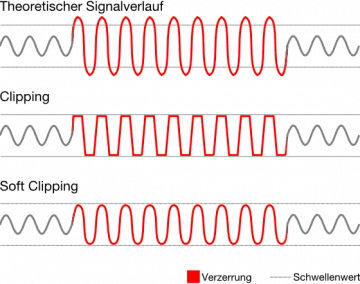

Source: https://www.delamar.de/faq/dezibel-db-dbfs-dba-30138/

In [3]:
CONST_DBFS_VALUES_TO_SET_TO = [-35, -30, -25, -20, -15]

def mergeAmbientAndDialogue (dialogue: str, bg: str, filetype: str):
    """ Merge the ambient soundtrack with the spoken dialogue, adjusting the volume if needed.
        
        Args:
            dialogue (str): Path to the Dialo-Audiofile
            bg (str): Path to the Ambient-Audiofile
        """
    # Load the audio files and prepare filenames and paths for saving
    dialogue_name, dialogue_file_extension = os.path.splitext(os.path.basename(dialogue))
    ambient_name, ambient_file_extension = os.path.splitext(os.path.basename(bg))
    dialogue_name = dialogue_name.replace("_full","")
    
    for target_dbfs in CONST_DBFS_VALUES_TO_SET_TO:
        dialogue_sound = AudioSegment.from_wav(dialogue)
        match filetype:
            case ".mp3":
                ambient_sound = AudioSegment.from_mp3(bg)
                # Ensure both files have the same sample rate and channels
                ambient_sound = ambient_sound.set_frame_rate(dialogue_sound.frame_rate)
                ambient_sound = ambient_sound.set_channels(dialogue_sound.channels)
            case ".wav":
                ambient_sound = AudioSegment.from_wav(bg)
            case _:
                print(f"Not defined, stop execution")
                break
        
        # Get the average dBFS
        cur_volume = ambient_sound.dBFS
        print(f"Current dBFS for Ambient (average loudness): {cur_volume}dBFS")
        
        # Adjust volume to target volume
        adjust_volume = target_dbfs - cur_volume
        print(f"Adjust volume: {adjust_volume}dBFS")
        print (f"Merging {dialogue_name} and {ambient_name} with volume adjustments of {adjust_volume} dBFS to reach {target_dbfs}dBFS.")
        ambient_sound = ambient_sound + adjust_volume
        
        # Get the duration of the dialogue in milliseconds
        dialogue_duration = len(dialogue_sound)

        # Loop the ambient sound to match or exceed the dialogue duration
        # Loop enough times so that the ambient sound covers the entire dialogue duration
        num_loops = (dialogue_duration // len(ambient_sound)) + 1
        looped_ambient = ambient_sound * num_loops

        # Trim the looped ambient sound to match the duration of the dialogue exactly
        looped_ambient = looped_ambient[:dialogue_duration]

        # Combine the dialog and the looped ambient sound
        combined = dialogue_sound.overlay(looped_ambient)

        # Combine export path
        export_path = os.path.join(config_data['output_dir'], f"{dialogue_name}_{ambient_name}_{target_dbfs}dBFS.wav")
        
        # Export the result to a new WAV file
        combined.export(export_path, format="wav")
        print(f"Merging completed! The file is saved as {dialogue_name}_{ambient_name}_{target_dbfs}dBFS.wav.")

If compressing of the ambient files is needed, run the following function:

In [4]:
def convert_wav_to_mp3(wav_file, mp3_file, bitrate="320k"):
    """Converting a .WAV-Audio file to .MP3 to work with the same filetype.

    Args:
        wav_file (Any): Path to the .WAV-File
        mp3_file (Any): Path to the .MP3-File
        bitrate (str, optional): _description_. Defaults to "320k".
    """
    subprocess.run(['ffmpeg', '-i', wav_file, '-b:a', bitrate, mp3_file])

In [ ]:
CONST_COMPRESS_AMBIENT = False

if (CONST_COMPRESS_AMBIENT):
    index = 1
    for ambient_file in Path(config_data['ambient_dir']).iterdir():
        convert_wav_to_mp3(ambient_file, f'output{index}.mp3')
        index += 1
else:
    for dialog_file in Path(config_data['source_dir']).iterdir():
        if dialog_file.is_file() and dialog_file.suffix.lower() == ".wav":
            print("-----------------------------------")
            print(f"Merging dialog file: {dialog_file}")
            for ambient_file in Path(config_data['ambient_dir']).iterdir():
                if ambient_file.is_file():
                    print(f"ambient file: {ambient_file}")
                    mergeAmbientAndDialogue(dialog_file, ambient_file, ambient_file.suffix.lower())

Before we end the script, we need to end the Logger Task and set the normal sys output back to it's original value.

In [6]:
# Reset stdout to default and close logger
sys.stdout = original_stdout
logger.close()